# Credit Card Default Prediction

### Executive Summary

The task is to predict whether users will default on their next credit card payment based on demographic information and activities (i.e., payment status, statement amount, and payment amount) for the past six billing cycles.

The dataset is imbalanced with a non-default to default ratio of 4 to 1. The dataset includes categorical, ordinal, and numeric features, which are already in numeric form. Based on the EDA, the numerical data is right-skewed and has several high-leverage points and multicollinearity issue. Therefore, a tree-based model is a relatively easy start, which does not require additional processing (e.g., dummy categorical). The analysis starts with Decision Tree Classifier as the base model and follows with Random Forest and Logistic Regression.

The analysis uses f1, recall, precision, and AUC scores as the model evaluation metrics. As the dataset is imbalanced, the accuracy score is not helpful (with null model accuracy of 78%). Further business analysis (e.g., cost analysis for false positive and false negative) is necessary to decide the right balance between FP and FN and, therefore, the best model.


### Table of Content
- [1. Data Preview / Cleaning](#1.-Data-Preview-/-Cleaning)
- [2. Exploratory Data Analysis / Cleaning](#2.-Exploratory-Data-Analysis-/-Cleaning)
    - [2.1 Check for Imbalanced Dataset](#2.1-Check-for-Imbalanced-Dataset)
    - [2.2 Data Visualization](#2.2-Data-Visualization)
    - [2.3 Pair Plot - Check for Obvious Separator](#2.3-Pair-Plot---Check-for-Obvious-Separator)
    - [2.4 Heatmap - Check for Multicollinearity](#2.4-Heatmap---Check-for-Multicollinearity)
- [3. Modeling](#3.-Modeling)
    - [3.1 Tree-Based Models](#3.1-Tree-Based-Models)
        - [3.1.1 Decision Tree - Base Model](#3.1.1-Decision-Tree---Base-Model)
        - [3.1.2 Ensamble - Random Forest](#3.1.2-Ensamble---Random-Forest)
    - [3.2 Model - Logistic Regression](#3.2-Model---Logistic-Regression)
        - [3.2.1 Base Model](#3.2.1-Base-Model)
        - [3.2.2 Model Tuning](#3.2.2-Model-Tuning)
- [4. Summary & Conclusion](#4.-Summary-&-Conclusion)
        


## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_roc_curve, classification_report


pd.options.display.max_columns=50

## Load Data

In [41]:
df = pd.read_excel('./data/default_of_credit_card_clients.xls', header=1, index_col=0)
df.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
ID                                                                         
1       20000    2          2         1   24      2      2     -1     -1   
2      120000    2          2         2   26     -1      2      0      0   
3       90000    2          2         2   34      0      0      0      0   
4       50000    2          2         1   37      0      0      0      0   
5       50000    1          2         1   57     -1      0     -1      0   

    PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
ID                                                                        
1      -2     -2       3913       3102        689          0          0   
2       0      2       2682       1725       2682       3272       3455   
3       0      0      29239      14027      13559      14331      14948   
4       0      0      46990      48233      49291      28314      28959   
5       0      0       8617       5670      35835      20940      19146   

    BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
ID                                                                          
1           0         0       689         0         0         0         0   
2        3261         0      1000      1000      1000         0      2000   
3       15549      1518      1500      1000      1000      1000      5000   
4       29547      2000      2019      1200      1100      1069      1000   
5       19131      2000     36681     10000      9000       689       679   

    default payment next month  
ID                              
1                            1  
2                            1  
3                            0  
4                            0  
5                            0

## 1. Data Preview / Cleaning
**Summary: The dataset is clean**
    - Size/Dimension: 30,000 entries, 23 features, 1 label
    - Missing Data: None
    - Data type: no abnormal datatypes

In [3]:
# Check data dimensions
df.shape

(30000, 24)

In [4]:
# Check millsing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

In [5]:
# rename columns
df.rename(columns={'default payment next month':'label'}, inplace=True)
df.columns = df.columns.str.lower()
df.head()

limit_bal  sex  education  marriage  age  pay_0  pay_2  pay_3  pay_4  \
ID                                                                         
1       20000    2          2         1   24      2      2     -1     -1   
2      120000    2          2         2   26     -1      2      0      0   
3       90000    2          2         2   34      0      0      0      0   
4       50000    2          2         1   37      0      0      0      0   
5       50000    1          2         1   57     -1      0     -1      0   

    pay_5  pay_6  bill_amt1  bill_amt2  bill_amt3  bill_amt4  bill_amt5  \
ID                                                                        
1      -2     -2       3913       3102        689          0          0   
2       0      2       2682       1725       2682       3272       3455   
3       0      0      29239      14027      13559      14331      14948   
4       0      0      46990      48233      49291      28314      28959   
5       0      0       8617       5670      35835      20940      19146   

    bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  pay_amt5  pay_amt6  \
ID                                                                          
1           0         0       689         0         0         0         0   
2        3261         0      1000      1000      1000         0      2000   
3       15549      1518      1500      1000      1000      1000      5000   
4       29547      2000      2019      1200      1100      1069      1000   
5       19131      2000     36681     10000      9000       689       679   

    label  
ID         
1       1  
2       1  
3       0  
4       0  
5       0

## 2. Exploratory Data Analysis / Cleaning

Based on the EDA, the dataset is imbalanced and has high leverage and multicollinearity issues. Since all data are in numeric form (including the categorical data), tree-based model (which requires minimal preprocessing and robust to high leverage and outliers) is an relatively east starting point.

#### Feature Variables

In [6]:
# Categorical features
cat_features = [
    'sex', 
    'education', 
    'marriage'
]

# Ordinal features
ord_features = [
    'pay_0',
    'pay_2',
    'pay_3',
    'pay_4',
    'pay_5',
    'pay_6'
]

# Numerical features
num_features = df.columns[~df.columns.isin(cat_features + ord_features + ['label'])]
print(num_features)

Index(['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4',
       'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3',
       'pay_amt4', 'pay_amt5', 'pay_amt6'],
      dtype='object')


### 2.1 Check for Imbalanced Dataset
Result: data is imbalanced
 - Default/non-default ~ 1/4: Data is imbalanced but not severely imbalanced
 - The baseline accuracy is 78%

In [7]:
df['label'].value_counts()

0    23364
1     6636
Name: label, dtype: int64

In [8]:
df['label'].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: label, dtype: float64

### 2.2 Description Statistics

Several Observations:
- minimum of sex, education, and marriage is 0. Not in the feature description. --> further investigation in EDA
- minimum of payment status is -2, which is not in the payment description. --> further investigation in EDA
- minimum value of bill amount is large negative number. In really it is possible (credit)
- most of the numerical features are right-skewed.

In [9]:
df.describe()

limit_bal           sex     education      marriage           age  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667      1.603733      1.853133      1.551867     35.485500   
std     129747.661567      0.489129      0.790349      0.521970      9.217904   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

              pay_0         pay_2         pay_3         pay_4         pay_5  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.016700     -0.133767     -0.166200     -0.220667     -0.266200   
std        1.123802      1.197186      1.196868      1.169139      1.133187   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      8.000000      8.000000      8.000000      8.000000   

              pay_6      bill_amt1      bill_amt2     bill_amt3  \
count  30000.000000   30000.000000   30000.000000  3.000000e+04   
mean      -0.291100   51223.330900   49179.075167  4.701315e+04   
std        1.149988   73635.860576   71173.768783  6.934939e+04   
min       -2.000000 -165580.000000  -69777.000000 -1.572640e+05   
25%       -1.000000    3558.750000    2984.750000  2.666250e+03   
50%        0.000000   22381.500000   21200.000000  2.008850e+04   
75%        0.000000   67091.000000   64006.250000  6.016475e+04   
max        8.000000  964511.000000  983931.000000  1.664089e+06   

           bill_amt4      bill_amt5      bill_amt6       pay_amt1  \
count   30000.000000   30000.000000   30000.000000   30000.000000   
mean    43262.948967   40311.400967   38871.760400    5663.580500   
std     64332.856134   60797.155770   59554.107537   16563.280354   
min   -170000.000000  -81334.000000 -339603.000000       0.000000   
25%      2326.750000    1763.000000    1256.000000    1000.000000   
50%     19052.000000   18104.500000   17071.000000    2100.000000   
75%     54506.000000   50190.500000   49198.250000    5006.000000   
max    891586.000000  927171.000000  961664.000000  873552.000000   

           pay_amt2      pay_amt3       pay_amt4       pay_amt5  \
count  3.000000e+04   30000.00000   30000.000000   30000.000000   
mean   5.921163e+03    5225.68150    4826.076867    4799.387633   
std    2.304087e+04   17606.96147   15666.159744   15278.305679   
min    0.000000e+00       0.00000       0.000000       0.000000   
25%    8.330000e+02     390.00000     296.000000     252.500000   
50%    2.009000e+03    1800.00000    1500.000000    1500.000000   
75%    5.000000e+03    4505.00000    4013.250000    4031.500000   
max    1.684259e+06  896040.00000  621000.000000  426529.000000   

            pay_amt6         label  
count   30000.000000  30000.000000  
mean     5215.502567      0.221200  
std     17777.465775      0.415062  
min         0.000000      0.000000  
25%       117.750000      0.000000  
50%      1500.000000      0.000000  
75%      4000.000000      0.000000  
max    528666.000000      1.000000

### 2.3 Data Visualization

#### Categorical Variable
- **Sex**: Male has higher default rate than female
- **Education**: The higher the education level, the lower the default rate. 0 is not in the feature description. Assume 0 as missing values. One possible solution is to impute 0 with the mode.
- **Marriage**: Married has higher default rate than single. 0 is not in the feature description. One possible solution is to impute 0 with the mode.

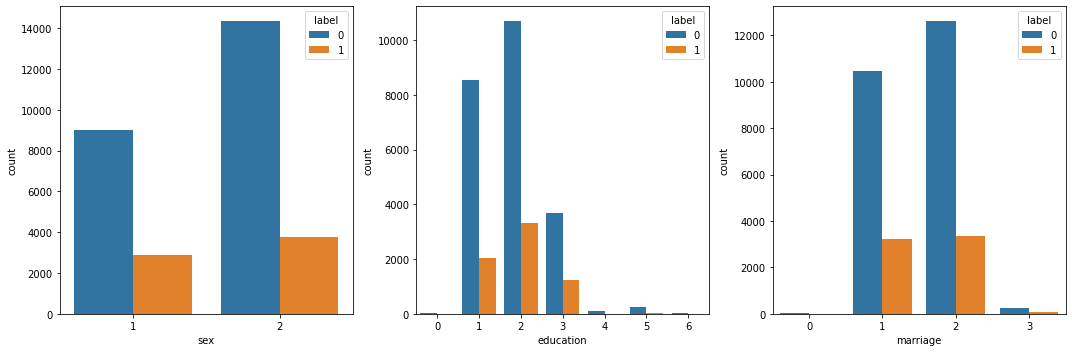

In [10]:
# plot default rate
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, f in enumerate(cat_features):
    sns.countplot(data=df, x=f, hue='label', ax=axes[i])
plt.tight_layout()

In [11]:
# Default rate for each category
for f in cat_features:
    print(df.groupby(f)['label'].mean())

sex
1    0.241672
2    0.207763
Name: label, dtype: float64
education
0    0.000000
1    0.192348
2    0.237349
3    0.251576
4    0.056911
5    0.064286
6    0.156863
Name: label, dtype: float64
marriage
0    0.092593
1    0.234717
2    0.209283
3    0.260062
Name: label, dtype: float64


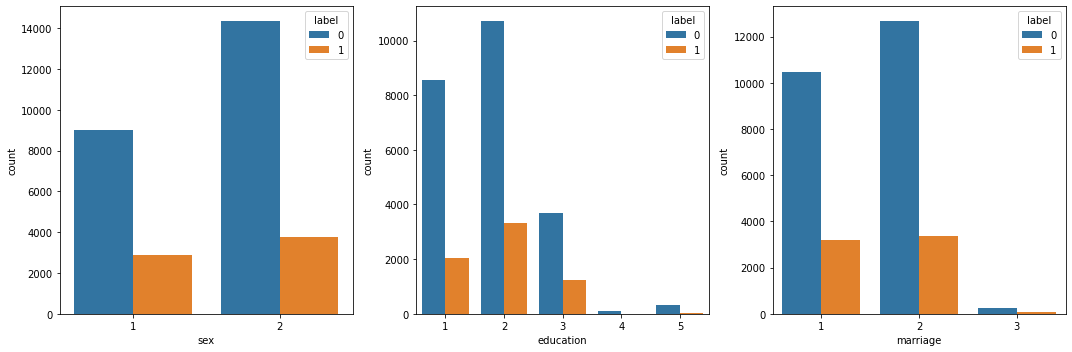

In [12]:
# Solution
# Impute education
df['education'] = df['education'].apply(lambda x: 2 if x == 0 else x)

# Group 5 and 6 to 5 for education.
df['education'] = df['education'].apply(lambda x: 5 if x == 6 else x)

# Impute marriage
df['marriage'] = df['marriage'].apply(lambda x: 2 if x == 0 else x)

# Confirm change
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, f in enumerate(cat_features):
    sns.countplot(data=df, x=f, hue='label', ax=axes[i])
plt.tight_layout()

#### Ordinal Variables

- Investigation: Values -2 and 0 are not in feature description. Based on investigation, it seems -2 and 0 are both an indication of pay duly.
- Solution: group -2, -1, 0 into one group 0 as pay duly.

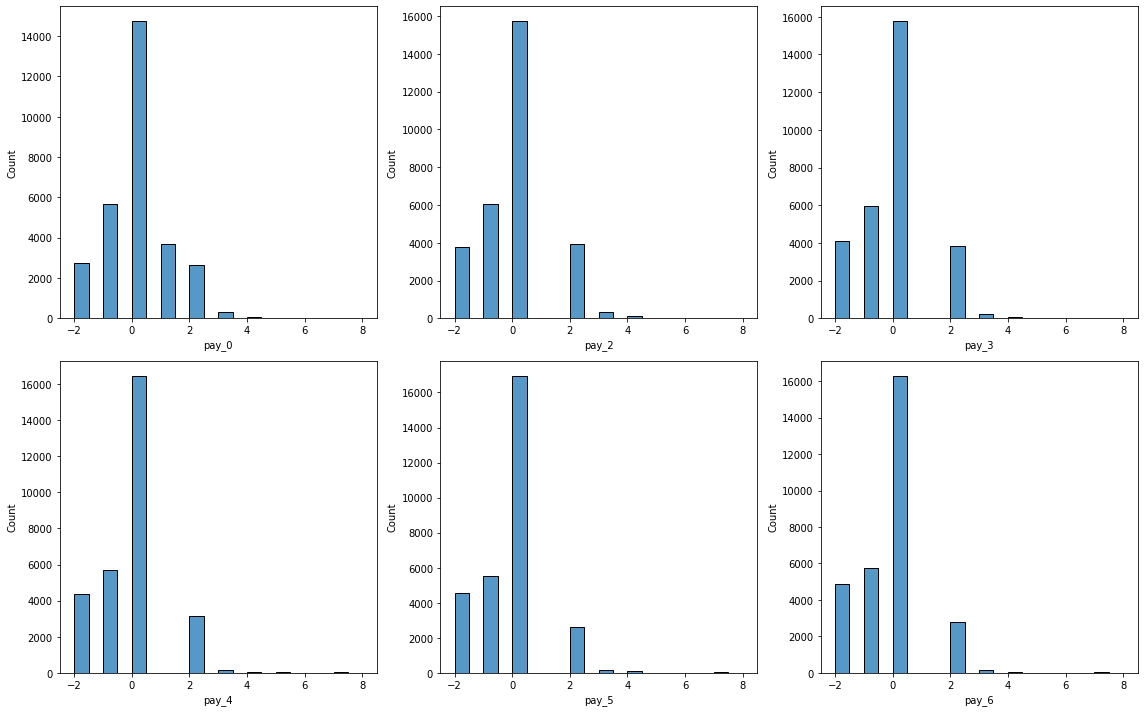

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for i, feat in enumerate(ord_features):
    axes = axes.ravel()
    sns.histplot(df[feat], bins=20, ax=axes[i])
plt.tight_layout()

In [14]:
# Investigation: -2
display(df[(df['pay_0'] == -2) & (df['label'] == 0)].sample(10))
display(df[(df['pay_0'] == -2) & (df['label'] == 1)].sample(10))
print(df[df['pay_0'] == -2]['label'].mean())

limit_bal  sex  education  marriage  age  pay_0  pay_2  pay_3  pay_4  \
ID                                                                            
13929     110000    2          1         1   31     -2     -2     -2     -2   
19238     220000    2          1         2   36     -2     -2     -2     -2   
28668     300000    2          1         1   40     -2     -2     -2     -2   
8619      230000    2          3         2   39     -2     -2     -2     -2   
18022      30000    1          3         1   44     -2     -2     -2     -2   
26312     210000    2          2         2   28     -2     -2     -2     -2   
23146     210000    2          2         1   37     -2     -2     -2     -2   
7142       30000    2          2         2   21     -2     -2     -2     -2   
9729      280000    2          3         2   46     -2     -2     -2     -2   
18649     240000    2          1         2   28     -2     -2     -2     -2   

       pay_5  pay_6  bill_amt1  bill_amt2  bill_amt3  bill_amt4  bill_amt5  \
ID                                                                           
13929     -2     -1          0          0          0          0        163   
19238     -2     -2        122        104       2635       2460        859   
28668     -2     -2       1529       3717       4541       5620         25   
8619      -2     -2       1876       1876       1876       2848       1876   
18022     -2     -2       2180          0          0          0          0   
26312     -2     -2          0          0          0       1577          0   
23146     -2     -2       2978       1798        379        768       2308   
7142      -2     -2          0        780       3260       4311       1551   
9729      -2     -2       1401       5201       3615       1963       2086   
18649     -2     -2       8451       1419      37307       1086       1494   

       bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  pay_amt5  pay_amt6  \
ID                                                                             
13929      63755         0         0         0       163     63755      2000   
19238       2784       104      2653      2472       859      2784      2287   
28668         25      3717      4541      5620        25         0      7140   
8619        4634      1876      1876      2848      1876      4634      1876   
18022          0         0         0         0         0         0         0   
26312          0         0         0      1577         0         0         0   
23146       1026      1798       379       768      2308      1026      1208   
7142           0       780      3260      4311      1551         0         0   
9729        1297      5201      3615      1963      2086      1297      1154   
18649       7724      1419     37307      1086      1494      7724      1101   

       label  
ID            
13929      0  
19238      0  
28668      0  
8619       0  
18022      0  
26312      0  
23146      0  
7142       0  
9729       0  
18649      0

limit_bal  sex  education  marriage  age  pay_0  pay_2  pay_3  pay_4  \
ID                                                                            
22911     360000    2          2         1   39     -2     -2     -2     -2   
22145     300000    2          1         2   29     -2     -2     -2     -2   
23507     260000    2          1         2   33     -2     -2     -2     -2   
20154     240000    2          2         1   37     -2     -2     -2     -2   
22506     310000    2          1         1   33     -2     -2     -2     -2   
11985     470000    2          1         2   30     -2     -1     -1     -2   
14913     330000    2          2         1   42     -2     -1      2      2   
17297     400000    2          2         2   32     -2     -2     -2     -2   
28050     150000    2          1         2   29     -2     -2     -2     -2   
16485     180000    2          1         2   56     -2     -2     -2     -2   

       pay_5  pay_6  bill_amt1  bill_amt2  bill_amt3  bill_amt4  bill_amt5  \
ID                                                                           
22911     -2     -2       4201          0          0          0          0   
22145     -2     -2       1049        205       4962      13634      41510   
23507     -2     -2      18480       3958        -86        -86      17315   
20154     -2     -2       -150       -150       -150       -150       -150   
22506     -2     -2       2729          0          0          0          0   
11985     -1     -1       1689        499        350       2277      41523   
14913     -2     -1         -4       8223       2996        207         -3   
17297     -2     -2       6464       -270       -770       -761      -2710   
28050     -2     -1          0       5067        131        987          0   
16485     -2     -2          0          0       1829       -200          0   

       bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  pay_amt5  pay_amt6  \
ID                                                                             
22911          0         0         0         0         0         0         0   
22145      -1087       205      4962     13634     41510         0      3940   
23507      14961      3978         0         0     17401     15036     18207   
20154       -150         0         0         0         0         0         0   
22506        343         0         0         0         0       343       410   
11985       2175       499       350      2277     41523      2175      6351   
14913        500     15450         0       209         3       503         0   
17297     187552      1692         0         9        11    194541      7015   
28050      14001      5067       131       987       400     14001         0   
16485       4208         0      1829       998       200      4208         0   

       label  
ID            
22911      1  
22145      1  
23507      1  
20154      1  
22506      1  
11985      1  
14913      1  
17297      1  
28050      1  
16485      1

0.13229430953243929


In [15]:
# Investigation: -1
display(df[(df['pay_0'] == 0) & (df['label'] == 0)].sample(10))
display(df[(df['pay_0'] == 0) & (df['label'] == 1)].sample(10))
print(df[df['pay_0'] == 0]['label'].mean())

limit_bal  sex  education  marriage  age  pay_0  pay_2  pay_3  pay_4  \
ID                                                                            
20975      60000    1          3         1   41      0      0      0      0   
23128     170000    2          2         1   29      0      0      0      0   
22684     140000    2          2         1   36      0      0      0      0   
18832     110000    2          3         2   31      0      0     -1     -1   
13382     500000    2          2         2   26      0      0      0      0   
500        20000    1          1         1   38      0      0      0      2   
596       200000    1          1         1   43      0      0      0      0   
19576     210000    2          1         1   31      0      0      0      0   
27383     180000    1          1         2   35      0      0      0      0   
5087       80000    2          2         2   23      0      0      0      0   

       pay_5  pay_6  bill_amt1  bill_amt2  bill_amt3  bill_amt4  bill_amt5  \
ID                                                                           
20975      0      0      58563      58344      57920      58064      55928   
23128      0      0      79091      62575      63317      63903      43505   
22684      0      0      50663      50847      50768      50629      49974   
18832     -1     -1       4061       2705       2487       2500       2500   
13382      0      0      59039      58262      54586      29280      31284   
500        2      0      15912      17272      20565      20705      20255   
596        0      0     144678     140804     136437     135253     134629   
19576      0      0     157544     160437     129247     119579     120318   
27383      0      0      52160      46545      43604      43571      19360   
5087       0     -1       4125      10174       6160       9020       4670   

       bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  pay_amt5  pay_amt6  \
ID                                                                             
20975      57108      2826      2269      2277      2002      2081      2395   
23128      43995      2235      2493      2585      1683      1901      2111   
22684      49897      1788      2182      2041      1715      1982     30000   
18832          0      1205      2487      2700      2500         0         0   
13382      29371      4028      2077      1001      3008      1305      1007   
500        19933      1623      3916       750         0       800       850   
596       134309      5090      5014      5009      4844      5002      4902   
19576     107122      7505      7072      4009      8000     10000     12000   
27383      20650      3022      3005      3002      3004      3000         0   
5087        6124      6174      3160      5020      1670      6124      1600   

       label  
ID            
20975      0  
23128      0  
22684      0  
18832      0  
13382      0  
500        0  
596        0  
19576      0  
27383      0  
5087       0

limit_bal  sex  education  marriage  age  pay_0  pay_2  pay_3  pay_4  \
ID                                                                            
4502      180000    1          2         1   36      0      0      0      0   
29860     190000    1          2         1   42      0      0      0      0   
3359      130000    2          2         1   28      0      0      0      0   
16289      30000    2          3         1   35      0      0      0      0   
14501     240000    2          2         1   29      0      0      2      2   
21304     360000    1          1         1   51      0      0      0      0   
14180     150000    1          2         2   23      0      0     -1      0   
4391       10000    2          2         2   21      0      0      0     -1   
29898     120000    1          3         1   47      0      0      0      0   
22091     320000    2          2         1   28      0      0      2      0   

       pay_5  pay_6  bill_amt1  bill_amt2  bill_amt3  bill_amt4  bill_amt5  \
ID                                                                           
4502      -1     -1       4524       6435       6894       8292      21866   
29860      0      0       3747       3313       4085       4742       5875   
3359       0      2     107216      91888      83975      76842      78093   
16289      0      0      27785      28786      26496      25098      26209   
14501      2      0     198128     211417     206386     219111     211373   
21304      0      0     346225     353200     337593     341528     350949   
14180      0      0     151686     147474       7474       8173      87500   
4391      -1     -2       8660       9756       8560        780          0   
29898      0      0      71777      73282      75499      77739      78666   
22091      0      0     320635     313060     293055     269585     248093   

       bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  pay_amt5  pay_amt6  \
ID                                                                             
4502           0      2000      1200      2000     21866         0         0   
29860       7037      1000      1004      1500      1500      1267      1500   
3359       67557      4000      4000      8000      6000         0      2500   
16289      25325      1800      1500      1450      1500      1500      1500   
14501     211215     16500         0     16007         7      8229      7621   
21304     355869     14562     13806     12303     15005     13729      7700   
14180      89731      3000    120000       823     80000      3684      4500   
4391           0      1800      1300       800         0      1900         0   
29898      80399      2700      3400      3500      2815      3000      3000   
22091     239025     12500        22     11155      9100      8700      9183   

       label  
ID            
4502       1  
29860      1  
3359       1  
16289      1  
14501      1  
21304      1  
14180      1  
4391       1  
29898      1  
22091      1

0.12811291307593134


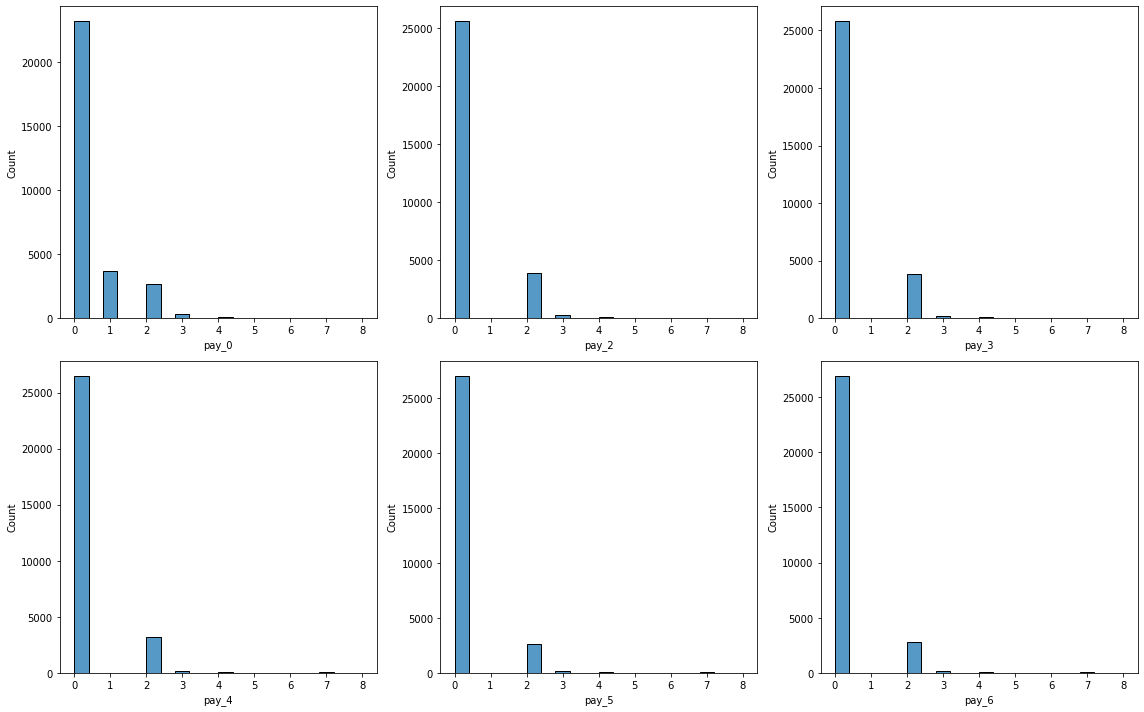

In [16]:
# Solution
# Replace -2, -1, 0 with 0
for f in ord_features:
    df[f] = df[f].apply(lambda x: 0 if x in [-2, -1, 0] else x)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot to confirm
for i, feat in enumerate(ord_features):
    axes = axes.ravel()
    sns.histplot(df[feat], bins=20, ax=axes[i])
plt.tight_layout()

#### Numerical Variable
- The payment status features seems normally distributed.
- All other features are right-skewed. One possible treatment is log these variable.
- There are negative bill amount. In reality, it is also possible. Based on the investigation, the negative bill amount is likely due to overpayment. Therefore, no action here.

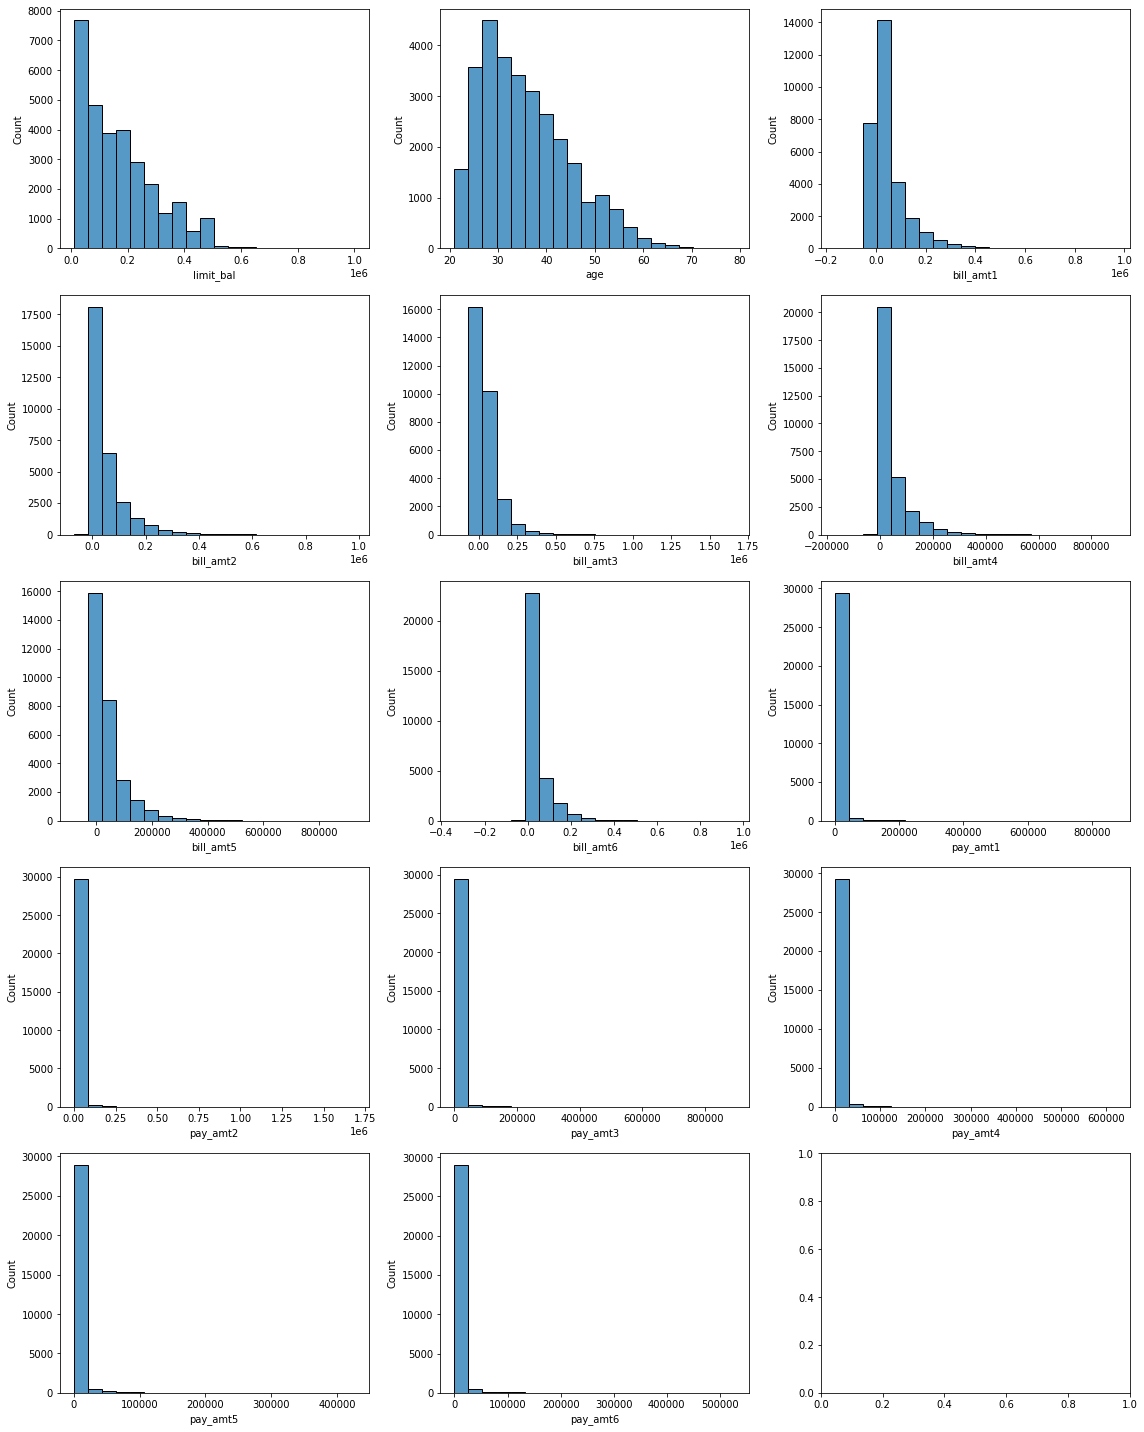

In [17]:
fig, axes = plt.subplots(5, 3, figsize=(16, 20))
for i, feat in enumerate(num_features):
    axes = axes.ravel()
    sns.histplot(df[feat], bins=20, ax=axes[i])
plt.tight_layout()

In [18]:
df[df['bill_amt1'] < 0]

limit_bal  sex  education  marriage  age  pay_0  pay_2  pay_3  pay_4  \
ID                                                                            
27         60000    1          1         2   27      1      0      0      0   
69        130000    2          3         2   29      1      0      0      0   
93        100000    2          1         2   27      0      0      0      0   
102       380000    2          1         2   30      0      0      0      0   
110       360000    1          2         1   35      1      0      0      0   
...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
29846      10000    1          2         1   37      1      0      0      3   
29852     270000    1          2         2   36      1      0      0      0   
29923     150000    1          2         1   35      1      0      0      0   
29963      50000    1          2         2   30      1      0      2      0   
29999      80000    1          3         1   41      1      0      0      0   

       pay_5  pay_6  bill_amt1  bill_amt2  bill_amt3  bill_amt4  bill_amt5  \
ID                                                                           
27         0      0       -109       -425        259        -57        127   
69         2      0       -190      -9850      -9850      10311      10161   
93         0      0      -2000       5555          0          0          0   
102        0      0        -81       -303      32475      32891      33564   
110        0      0       -103       -103       -103       -103       -103   
...      ...    ...        ...        ...        ...        ...        ...   
29846      2      0       -265       -265       5235       5007       4779   
29852      0      0        -16       3326        -54        -54      19315   
29923      0      0        -18        -18        -18        -18        -18   
29963      0      0       -264        264        264       7300          0   
29999      0      0      -1645      78379      76304      52774      11855   

       bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  pay_amt5  pay_amt6  \
ID                                                                             
27          -189         0      1000         0       500         0      1000   
69          7319         0         0     20161         0      7319     13899   
93             0      7555         0         0         0         0         0   
102        34056       223     33178      1171      1197      1250      5000   
110         -103         0         0         0         0         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
29846       7680         0      5500         0         0      3000      2000   
29852       8388      3342         0         0     19369       996         3   
29923        -18         0         0         0         0         0         0   
29963          0       528         0      7300         0         0         0   
29999      48944     85900      3409      1178      1926     52964      1804   

       label  
ID            
27         1  
69         0  
93         0  
102        0  
110        0  
...      ...  
29846      1  
29852      0  
29923      0  
29963      0  
29999      1  

[590 rows x 24 columns]

### 2.4 Pair Plot - Check for Obvious Separator
Several observed patterns:
- Payment status group: more month delayed -> more likely to default
- Payment amount: 0 (not paying) -> more likely to default (make sense)

Issues:
- The feature data seems to have several high leverage data points (not good for linear model).

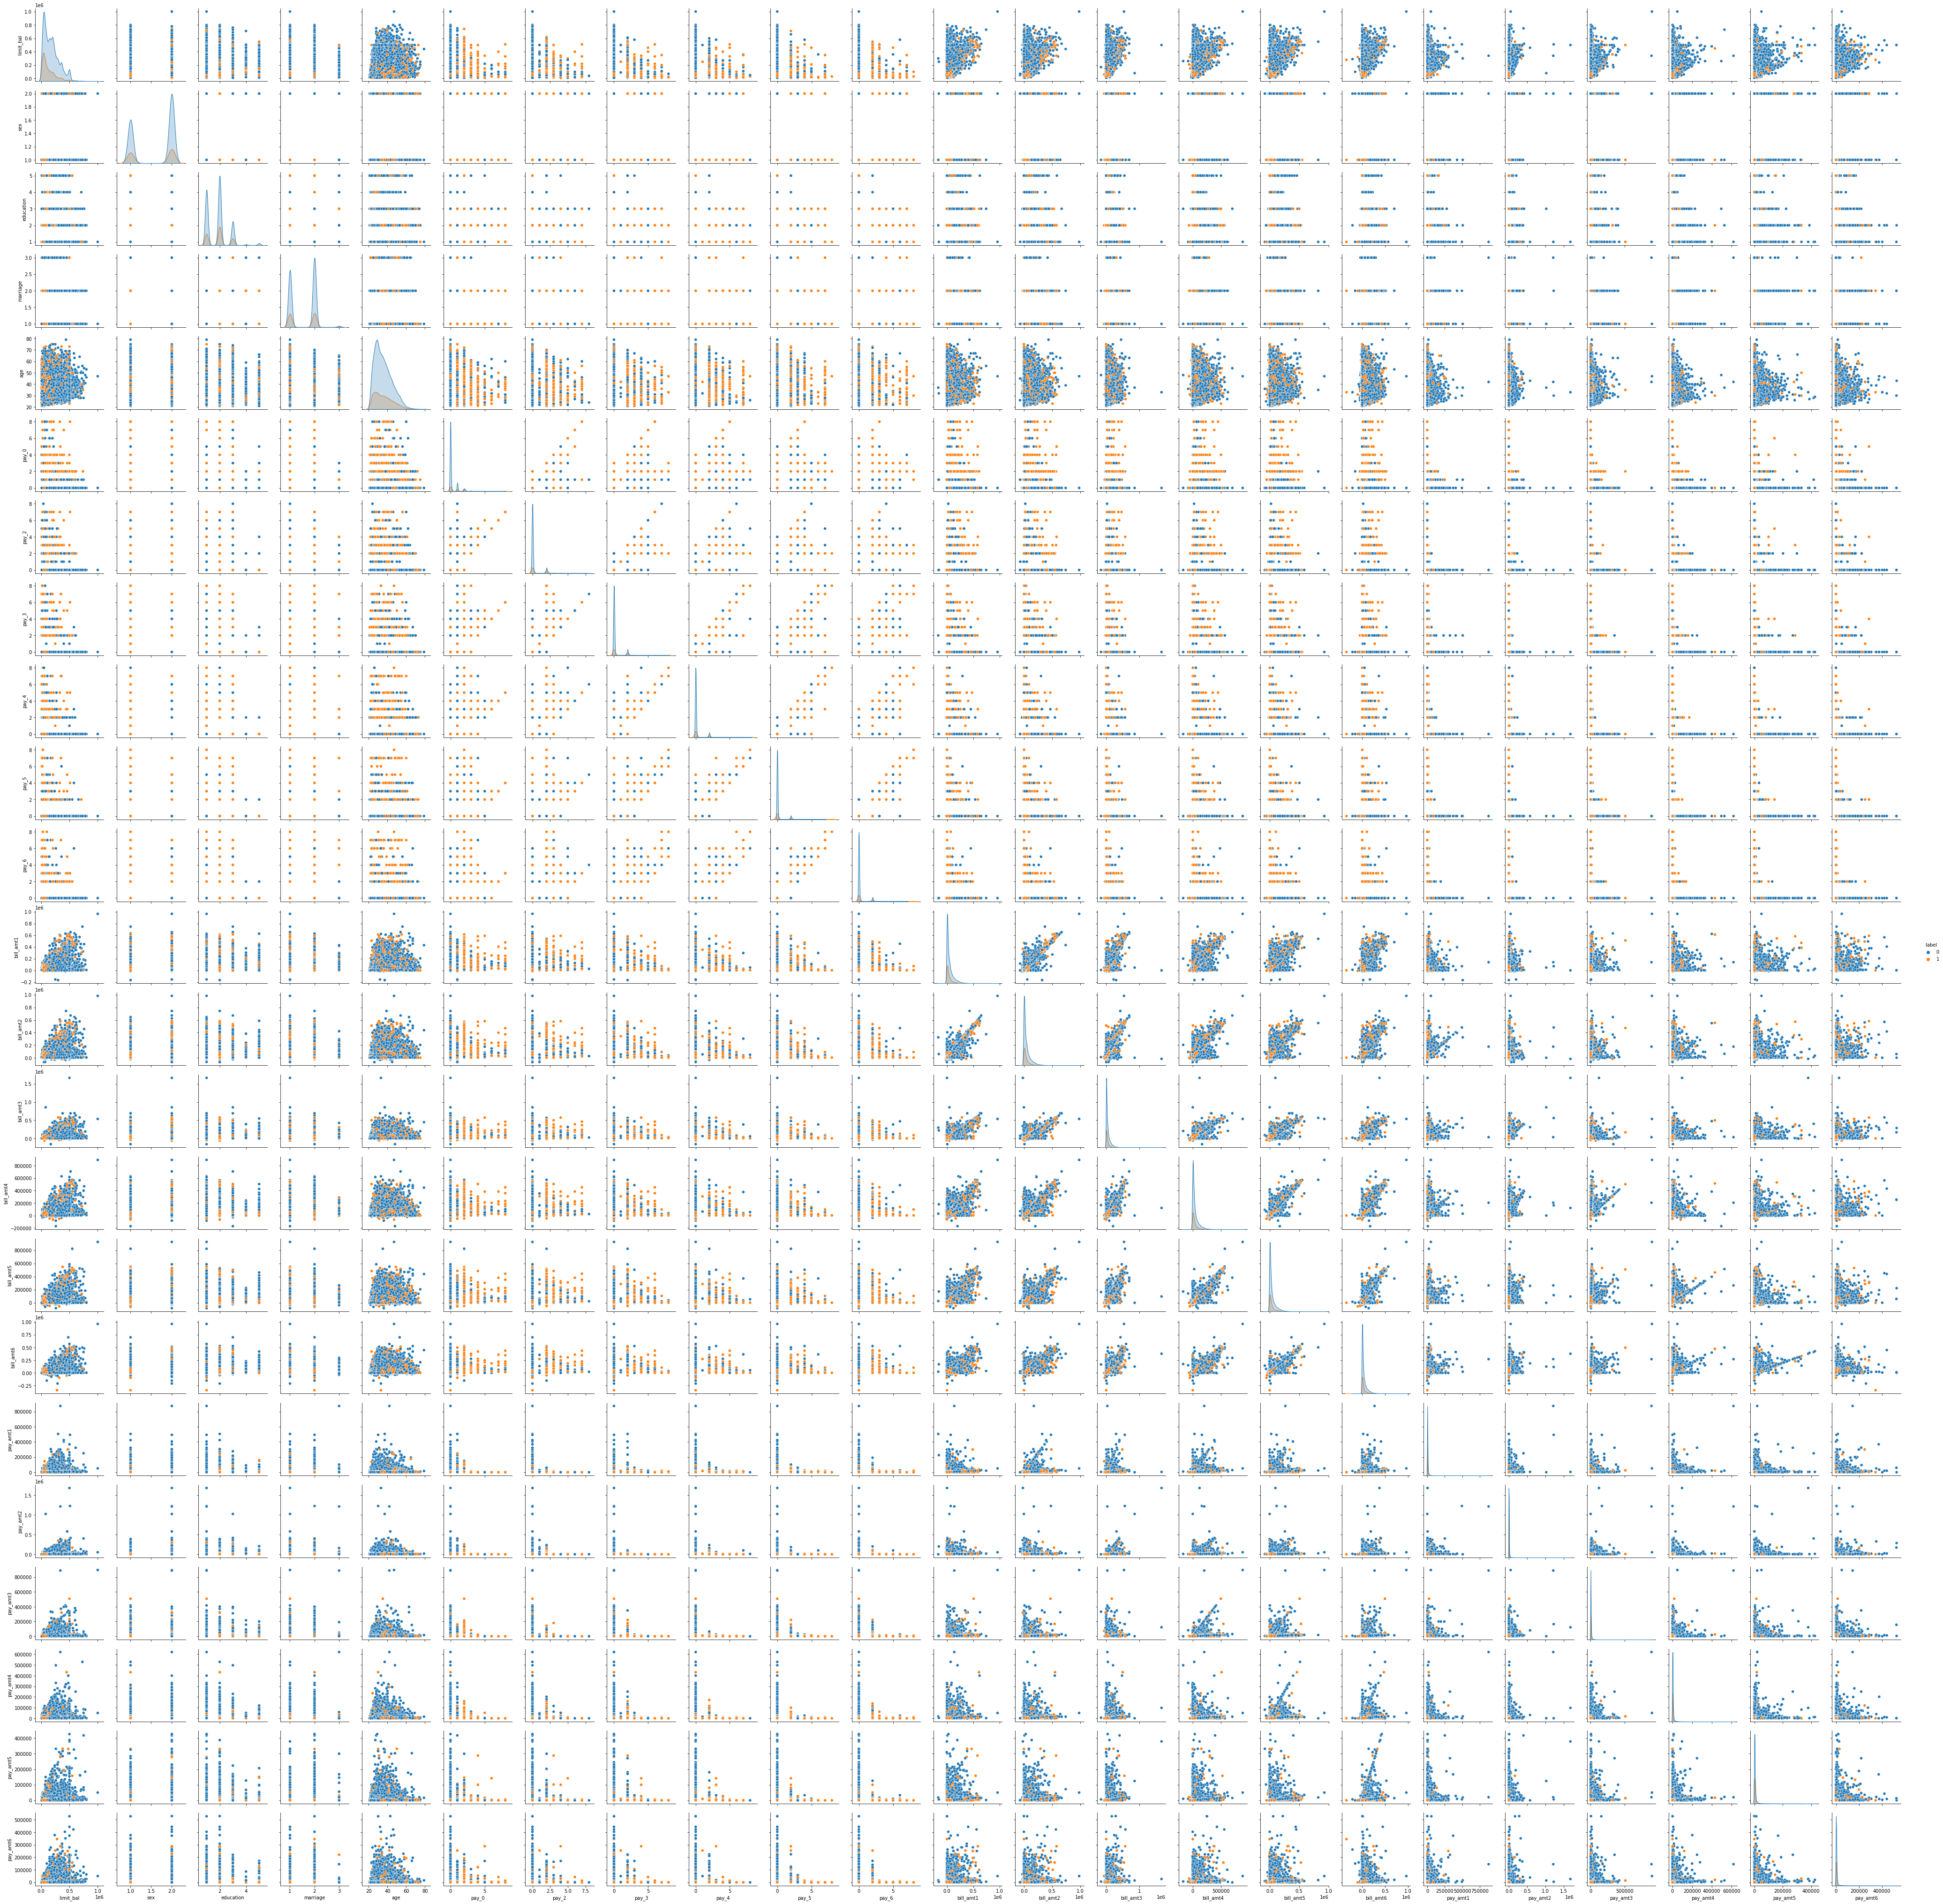

In [19]:
sns.pairplot(df, hue='label');

### 2.5 Heatmap - Check for Multicollinearity

- There are multicollinearity issues among two feature groups:
    - payment status (i.e., pay_#)
    - bill/statement amount (i.e., bill_amt#)

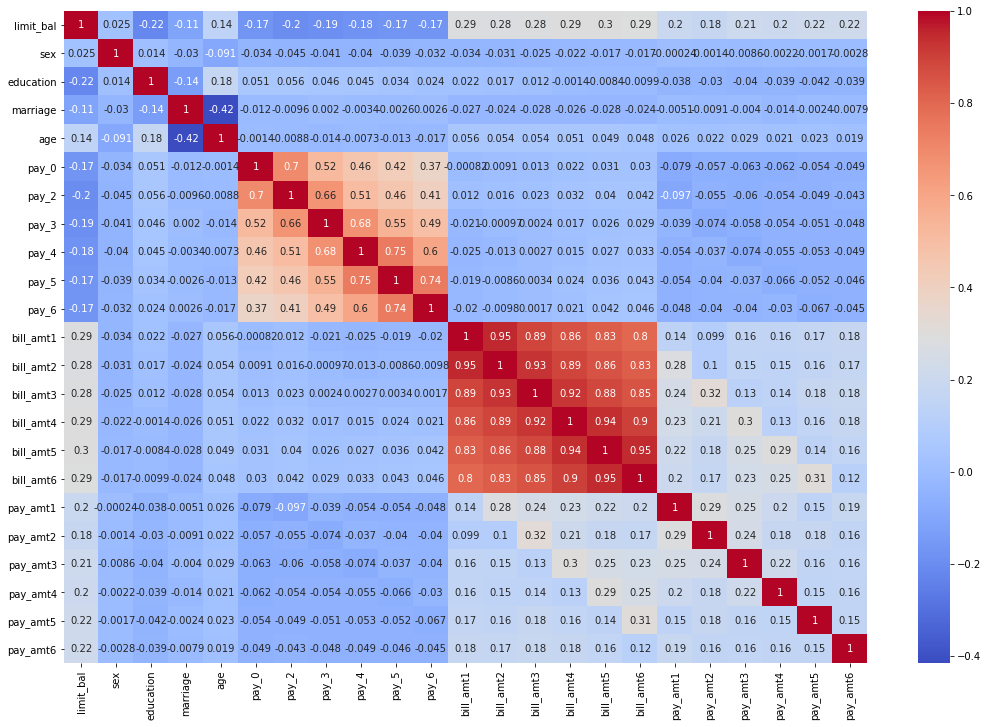

In [20]:
plt.figure(figsize=(18, 12))
sns.heatmap(df.drop(columns=['label']).corr(), cmap='coolwarm', annot=True);

## 3. Modeling

#### Helper Functions

In [21]:
def model_tuning_gridsearch(classifier, X_train, X_test, y_train, param_grid, pipeline=False, scoring='f1'):
    """
    Tuning a machine learning model using GridSearch
    
    Parameters:
    -----------
    classifier: ML classifier or pipeline object. 
        
    X_train: pandas dataframe
        Training data features.
    X_test: pandas dataframe
        Testing data features.
    y_train: pandas series or numpy array
        Training data target.
    param_grid: dictionary
        Parameters used for GridSearch
    pipeline: boolean, default=False
        Whether the classifier input parameter is a pipeline object
    scoring: str, default='f1'
        Strategy to evaluate the performance of the cross-validated model on
        the test set.
    
    Outputs: tuple
    ----------
    best_estimator: 
        bestor estimator from gridsearch
    y_pred: numpy array
        predict testing data target
    """
    
    # instantiate classifier
    if pipeline:
        clf = classifier
    else:
        clf = classifier()
    
    # istantiate gridsearch
    gs = GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        n_jobs=-1,
        verbose=2,
        cv=5,
        scoring=scoring
    )
    
    # model fit
    gs.fit(X_train, y_train)
    
    # predit testing label
    y_pred = gs.predict(X_test)
    print(f'The best parameters associated with {scoring} score is: {gs.best_params_}')
    print(f'The best cross-validation {scoring} score is: {gs.best_score_}')
    return gs.best_estimator_, y_pred

def model_evaluation(model, X_test, y_test, y_pred, scoring):
    """
    Generates confusion matrix, classification report, 
    and ROC curve
    
    Parameters:
    ----------
    models: ML model object
    X_test: pandas dataframe
        Testing data features
    y_test: pandas series or numpy array
        Testing data target
    y_pred: numpy array
        Predicted testing target
    scoring: str
        Strategy to evaluate the performance of the 
        cross-validated model on the test set.
    """
    
    # generate confusion matrix
    print()
    print('-------------- Confusion Matrix --------------')
    cf = pd.DataFrame(
        confusion_matrix(y_test, y_pred), 
        columns=['Pred False', 'Pred True'],
        index=['True False', 'True True']
    )
    display(cf)
    
    # generate classification report
    print()
    print('---------------- Test Scores -----------------')
    print(classification_report(y_test, y_pred))
    
    # Plot ROC curve
    plot_roc_curve(model, X_test, y_test, name=scoring)

def plot_feature_importance(data, X_train, model_type):
    """
    Visualizes feature importance attribute (absolute value) 
    in a horizontal bar chart
    
    Parameters:
    ----------
    data: pandas series or numpy array
        Feature importance data. For instance 
        - feature coefficient from linear models
        - feature importance attribute from tree-based models
    X_train: pandas series or numpy array
        Training data target.
    model_type: str
        Description of model (e.g., Logistic Regression)
    """
    
    # calculate absolute value of feature importance attribute
    data_abs = np.abs(data)
    
    # Create feature importance dataframe and sort the values
    feat_imp = pd.DataFrame(
        data_abs,
        columns=['importance'],
        index=X_train.columns
    ).sort_values(by='importance', ascending=False)
    
    # Plot feature importance in a horizontal bar chart
    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=feat_imp, 
        y=feat_imp.index, 
        x='importance',
        orient='h');
    plt.title(f'Feature Importance - {model_type}')
    plt.tight_layout();

## 3.1 Tree-Based Models
The advantage of tree-based models include:
    - minimal preprocessing (i.e., no need to dummify categorical variables)
    - Robust to outliers
Based on the result of EDA, tree-based model is an easy starting point.

#### Data Preprocessing / Feature Engineering

In [22]:
X_t = df.drop(columns=['label'])
y_t = df['label']
print(X_t.shape)
print(y_t.shape)

(30000, 23)
(30000,)


#### Train / Test Split

In [23]:
# Using stratify argument to ensure same ratio of 0 and 1 in both train and test set
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, random_state=42, stratify=y_t)
print(X_train_t.shape)
print(y_train_t.shape)
print(X_test_t.shape)
print(y_test_t.shape)

(22500, 23)
(22500,)
(7500, 23)
(7500,)


### 3.1.1 Decision Tree - Base Model

----------- Cross Validation ------------
Base model cv accuracy: 0.8090666666666667
Base model cv recall: 0.36347157474117575
Base model cv precision: 0.6180981753462357
Base model cv f1: 0.4561360434034881

-------------- Confusion Matrix --------------


Pred False  Pred True
True False        5476        365
True True         1055        604


---------------- Test Scores -----------------
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      5841
           1       0.62      0.36      0.46      1659

    accuracy                           0.81      7500
   macro avg       0.73      0.65      0.67      7500
weighted avg       0.79      0.81      0.79      7500



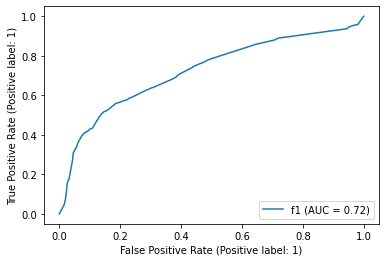

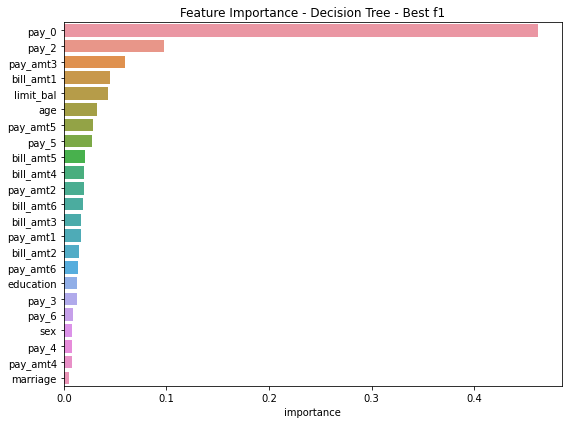

In [25]:
# Instantiate the decision tree model
dt = DecisionTreeClassifier(max_depth=10)

# k-fold crossvalidation
print('----------- Cross Validation ------------')
for scoring in ['accuracy', 'recall', 'precision', 'f1']:
    print(f'Base model cv {scoring}: {(cross_val_score(dt, X_train_t, y_train_t, cv=5, scoring=scoring).mean())}')

# fit the model
dt.fit(X_train_t, y_train_t)

# predict the target
y_pred_t = dt.predict(X_test_t)

# Model evaluation
# Classificaiton report & ROC plot
model_evaluation(dt, X_test_t, y_test_t, y_pred_t, scoring='f1')

# Visualize feature importance
plot_feature_importance(dt.feature_importances_, X_train_t, model_type=f'Decision Tree - Best f1')

### 3.1.2 Ensamble - Random Forest

In [26]:
# gridsearch parameters
param_grid = {
    'min_samples_leaf': [32, 64, 100], # Based on experience
    'class_weight': [None, 'balanced', 'balanced_subsample', {0:2, 1:1}] # address imbalanced data
}

================ Model with Best f1 ================

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best parameters associated with f1 score is: {'class_weight': 'balanced', 'min_samples_leaf': 32}
The best cross-validation f1 score is: 0.5450157401850945

-------------- Confusion Matrix --------------


Pred False  Pred True
True False        4782       1059
True True          662        997


---------------- Test Scores -----------------
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      5841
           1       0.48      0.60      0.54      1659

    accuracy                           0.77      7500
   macro avg       0.68      0.71      0.69      7500
weighted avg       0.79      0.77      0.78      7500



================ Model with Best recall ================

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best parameters associated with recall score is: {'class_weight': 'balanced_subsample', 'min_samples_leaf': 100}
The best cross-validation recall score is: 0.6300984843898206

-------------- Confusion Matrix --------------


Pred False  Pred True
True False        4679       1162
True True          620       1039


---------------- Test Scores -----------------
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      5841
           1       0.47      0.63      0.54      1659

    accuracy                           0.76      7500
   macro avg       0.68      0.71      0.69      7500
weighted avg       0.79      0.76      0.77      7500



================ Model with Best precision ================

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best parameters associated with precision score is: {'class_weight': {0: 2, 1: 1}, 'min_samples_leaf': 64}
The best cross-validation precision score is: 0.7514941089582783

-------------- Confusion Matrix --------------


Pred False  Pred True
True False        5770         71
True True         1403        256


---------------- Test Scores -----------------
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      5841
           1       0.78      0.15      0.26      1659

    accuracy                           0.80      7500
   macro avg       0.79      0.57      0.57      7500
weighted avg       0.80      0.80      0.75      7500





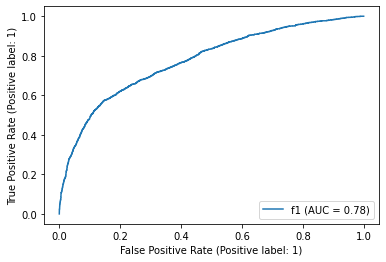

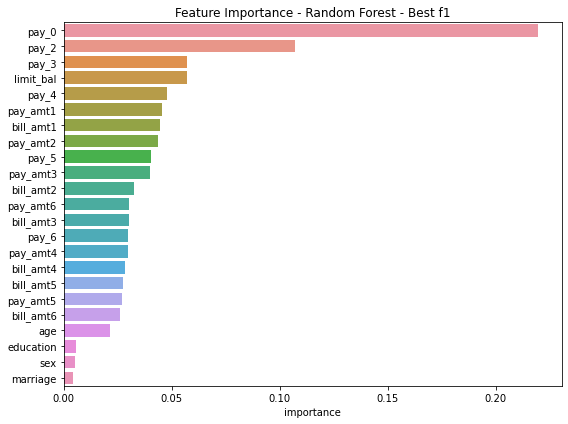

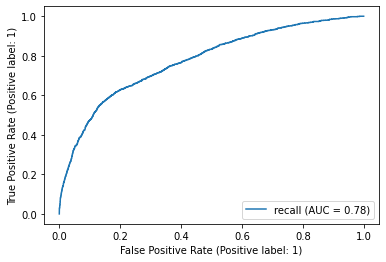

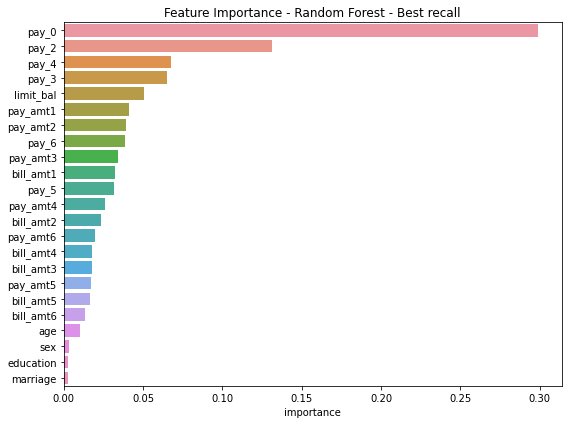

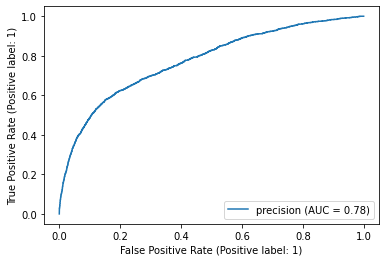

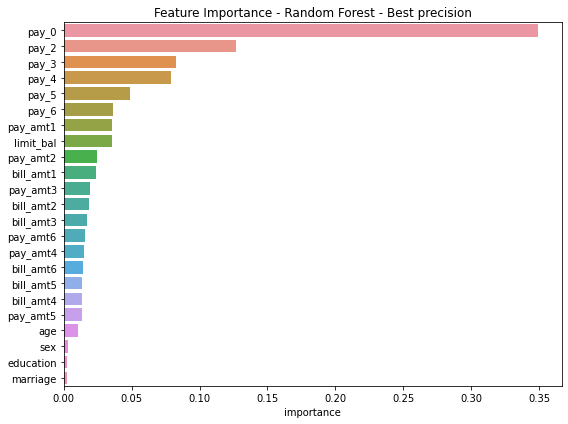

In [28]:
# Tuning model based on f1, recall, and precision separately
for scoring in ['f1', 'recall', 'precision']:
    print(f'================ Model with Best {scoring} ================')
    print()
    tree_model, y_pred_t = model_tuning_gridsearch(
        RandomForestClassifier, 
        X_train_t, 
        X_test_t, 
        y_train_t,
        param_grid=param_grid,
        scoring=scoring
    )
    model_evaluation(tree_model, X_test_t, y_test_t, y_pred_t, scoring=scoring)
    print()
    print()
    plot_feature_importance(
        tree_model.feature_importances_, 
        X_train_t, 
        model_type=f'Random Forest - Best {scoring}'
    )

## 3.2 Model - Logistic Regression

### Prerocessing / Feature Engineering

#### Dummify Categorical Variables

In [29]:
df_lr = pd.get_dummies(df, columns=cat_features, drop_first=True)
df_lr.head()

limit_bal  age  pay_0  pay_2  pay_3  pay_4  pay_5  pay_6  bill_amt1  \
ID                                                                        
1       20000   24      2      2      0      0      0      0       3913   
2      120000   26      0      2      0      0      0      2       2682   
3       90000   34      0      0      0      0      0      0      29239   
4       50000   37      0      0      0      0      0      0      46990   
5       50000   57      0      0      0      0      0      0       8617   

    bill_amt2  bill_amt3  bill_amt4  bill_amt5  bill_amt6  pay_amt1  pay_amt2  \
ID                                                                              
1        3102        689          0          0          0         0       689   
2        1725       2682       3272       3455       3261         0      1000   
3       14027      13559      14331      14948      15549      1518      1500   
4       48233      49291      28314      28959      29547      2000      2019   
5        5670      35835      20940      19146      19131      2000     36681   

    pay_amt3  pay_amt4  pay_amt5  pay_amt6  label  sex_2  education_2  \
ID                                                                      
1          0         0         0         0      1      1            1   
2       1000      1000         0      2000      1      1            1   
3       1000      1000      1000      5000      0      1            1   
4       1200      1100      1069      1000      0      1            1   
5      10000      9000       689       679      0      0            1   

    education_3  education_4  education_5  marriage_2  marriage_3  
ID                                                                 
1             0            0            0           0           0  
2             0            0            0           1           0  
3             0            0            0           1           0  
4             0            0            0           0           0  
5             0            0            0           0           0

#### Separate feature and target variables

In [30]:
X_lr = df_lr.drop(columns=['label'])
y_lr = df_lr['label']
print(X_lr.shape)
print(y_lr.shape)

(30000, 27)
(30000,)


#### Train / Test Split

In [31]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, random_state=42, stratify=y_lr)
print(X_train_lr.shape)
print(X_test_lr.shape)
print(y_train_lr.shape)
print(y_test_lr.shape)

(22500, 27)
(7500, 27)
(22500,)
(7500,)


### 3.2.1 Base Model

#### Model Training

In [32]:
sc = StandardScaler()
X_train_lr_sc = sc.fit_transform(X_train_lr)
X_test_lr_sc = sc.transform(X_test_lr)

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train_lr_sc, y_train_lr)
y_pred_lr = lr.predict(X_test_lr_sc)


-------------- Confusion Matrix --------------


Pred False  Pred True
True False        5571        270
True True         1106        553


---------------- Test Scores -----------------
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      5841
           1       0.67      0.33      0.45      1659

    accuracy                           0.82      7500
   macro avg       0.75      0.64      0.67      7500
weighted avg       0.80      0.82      0.79      7500



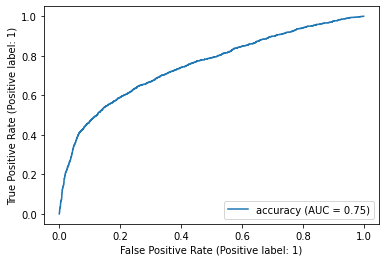

In [34]:
model_evaluation(lr, X_test_lr_sc, y_test_lr, y_pred_lr, scoring='accuracy')

#### Feature Importance

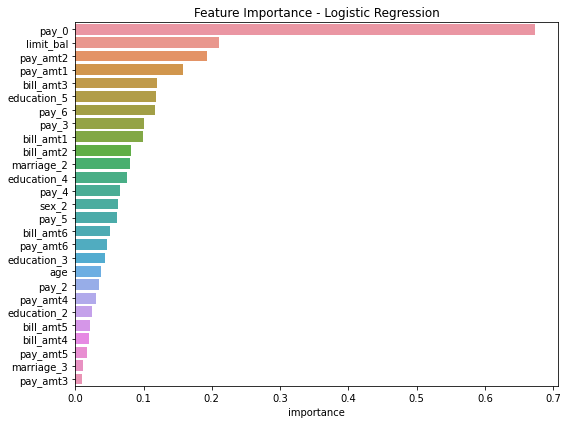

In [35]:
plot_feature_importance(lr.coef_.T, X_train_lr, model_type='Logistic Regression')

### 3.2.2 Model Tuning

#### Column Transformer

In [36]:
# Use powertransformer to address right-skewed numerical data
# The powertransformer also standardizes the output by default
column_trans = ColumnTransformer(
    [('pw', PowerTransformer(), num_features)],
    remainder='passthrough'
)

#### Pipeline Setup

In [37]:
pipe = Pipeline([
    ('column_trans', column_trans),
    ('lr', LogisticRegression(solver='liblinear'))
])

param_grid = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [0.01, 0.1, 1.0],
    'lr__class_weight': [None, 'balanced', {0:2, 1:1}]
}

#### GridSearch

================ Model with Best f1 ================

Fitting 5 folds for each of 18 candidates, totalling 90 fits
The best parameters associated with f1 score is: {'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2'}
The best cross-validation f1 score is: 0.5295688869144859

-------------- Confusion Matrix --------------


Pred False  Pred True
True False        4729       1112
True True          683        976


---------------- Test Scores -----------------
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      5841
           1       0.47      0.59      0.52      1659

    accuracy                           0.76      7500
   macro avg       0.67      0.70      0.68      7500
weighted avg       0.78      0.76      0.77      7500



================ Model with Best recall ================

Fitting 5 folds for each of 18 candidates, totalling 90 fits
The best parameters associated with recall score is: {'lr__C': 0.01, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2'}
The best cross-validation recall score is: 0.6023684688502755

-------------- Confusion Matrix --------------


Pred False  Pred True
True False        4716       1125
True True          675        984


---------------- Test Scores -----------------
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      5841
           1       0.47      0.59      0.52      1659

    accuracy                           0.76      7500
   macro avg       0.67      0.70      0.68      7500
weighted avg       0.78      0.76      0.77      7500



================ Model with Best precision ================

Fitting 5 folds for each of 18 candidates, totalling 90 fits
The best parameters associated with precision score is: {'lr__C': 0.1, 'lr__class_weight': {0: 2, 1: 1}, 'lr__penalty': 'l1'}
The best cross-validation precision score is: 0.7299193918218165

-------------- Confusion Matrix --------------


Pred False  Pred True
True False        5762         79
True True         1412        247


---------------- Test Scores -----------------
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      5841
           1       0.76      0.15      0.25      1659

    accuracy                           0.80      7500
   macro avg       0.78      0.57      0.57      7500
weighted avg       0.79      0.80      0.74      7500





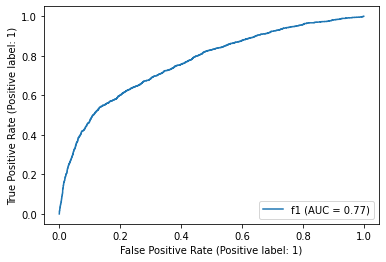

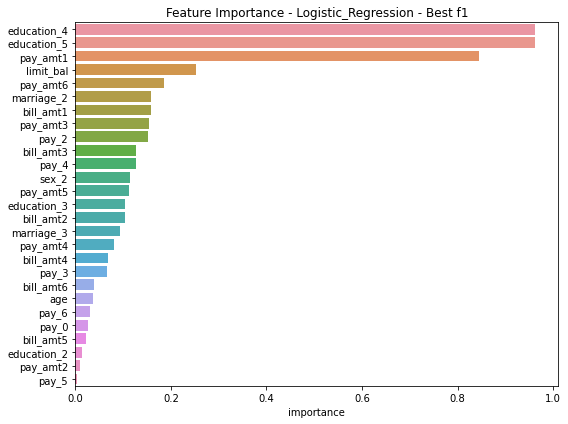

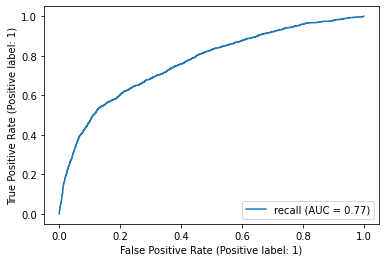

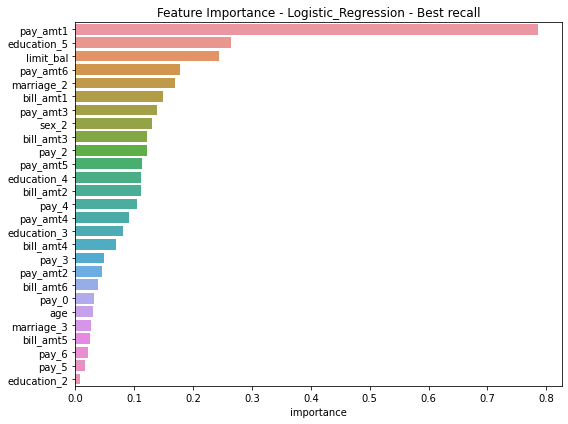

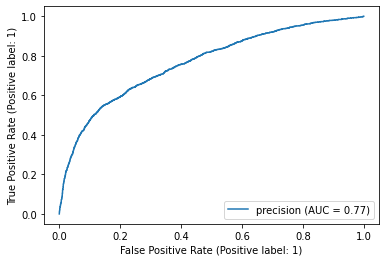

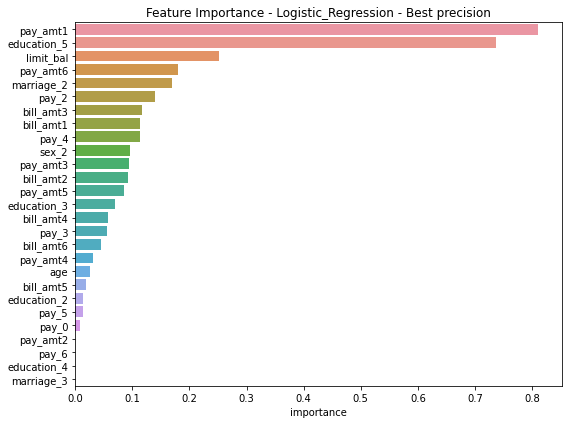

In [40]:
for scoring in ['f1', 'recall', 'precision']:
    print(f'================ Model with Best {scoring} ================')
    print()
    model, y_pred_lr = model_tuning_gridsearch(
        pipe, 
        X_train_lr, 
        X_test_lr, 
        y_train_lr,
        param_grid=param_grid,
        pipeline=True,
        scoring=scoring
    )
    model_evaluation(model, X_test_lr, y_test_lr, y_pred_lr, scoring=scoring)
    print()
    print()
    plot_feature_importance(
        model.named_steps['lr'].coef_.T, 
        X_train_lr, 
        model_type=f'Logistic_Regression - Best {scoring}'
    )

## 4. Summary & Next Step

**Summary**

Model with best F1: 0.54
 - **Rancom Forest** with parameters: {'class_weight': 'balanced', 'min_samples_leaf': 32}
 - Cost:
     - Recall: 0.61
     - precision: 0.49

Model with best Recall: 0.62 - Also Best AUC score.
 - **Rancom Fores** with parameters: {'class_weight': 'balanced_subsample', 'min_samples_leaf': 64}
 - Cost: 
     - Presision: 0.47
     - F1: 0.54

Model with best Precision: 0.76
 - **Logistic Regression** with parameters: {'lr__C': 0.1, 'lr__class_weight': {0: 2, 1: 1}, 'lr__penalty': 'l1'}
 - Cost:
     - Recall: 0.15
     - F1: 0.25
 


**Next Step**

Choosing the best model is a business decision. Below are recommended steps:
- Perform a cost analysis on False Positive and False Negative. 
- Discuss with business decision maker and find the right balance between FP and FN.
- Choose the best model that meets the business needs.